# What Makes the Most Popular Country for Studying Abroad?

#### By: Richard Mu and Xinyao Chen
### Introduction
Studying abroad has appeared to be increasing in popularity in recent years both in the Univeristy of Maryland and in other Universities across the United States. University of Maryland alone offers semester exchange program to over 60 countries around the world.

While we are excited to see that students has became more enthusiastic and understanding on the purpose and benefits of studying abroad, we also wanted to examine various attributes of the countries to see which ones may be the most suitable for studying abroad. We understand that selecting a country to study abroad in is a decision that each students make base on various factors, such as personal sentient and ethnic background. However, we are also curious about how the characteristics of each country, such as crime rates, may relate to the number of students studying abroad there.
### 1. DATA COLLECTION
There are several Python libraries that will be helpful in the process of our analysis. We will explain their functionality throughout this tutorial as they appear. Here are some documentation pages that we found convenient for referencing:<br>
1. [pandas library](https://pandas.pydata.org/pandas-docs/stable/)
2. [NumPy Manual](https://docs.scipy.org/doc/numpy/index.html)
3. [matplotlib pyplot library](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html)
4. [BeautifulSoup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
5. [Seaborn Visualization](https://seaborn.pydata.org/index.html)


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import warnings
import requests
import re
from bs4 import BeautifulSoup
import seaborn as sns
import folium
pd.set_option('display.max_rows', 600)   # Set full visualization of dataframes 
warnings.filterwarnings('ignore')

After several attemps, we realized that there is not a collective source that contains all the information we would like to analyze, so we decided process data from multiple sources and combine them to create the most all-round dataset.
<br>
First, we found a [dataset](https://www.iie.org/Research-and-Insights/Open-Doors/Data/US-Study-Abroad/Destinations) that listed the number of students in the United States that studied abroad at each country in the 2017-2018 school year. The data was downloaded as an excel sheet (or .xlsx) format so we simply used a Pandas function to read it into a Pandas DataFrame.

In [2]:
travel_data_2017 = pd.read_excel(open('D3A1FE70.xlsx', 'rb'),
                           sheet_name = "data")
travel_data_2017.head(10)

,Destination,2017/18
0,Cameroon,57
1,Central African Republic,0
2,Chad,2
3,"Congo, Dem. Rep. of (Kinshasa)",6
4,"Congo, Rep. of (Brazzaville)",5
5,Equatorial Guinea,7
6,Gabon,4
7,São Tomé and Príncipe,0
8,Burundi,0
9,Djibouti,0


In addition, we decided to choose three attributes that each will represent a different perspective of each country to help us give characterization.
<br><br>
__First Attribute: Peacefulness__
<br>
As students studying in a foreign country, we may often find ourselves worreid of places with high crime rates or recent violent uprisings. We found a [Global Peace Index](https://www.kaggle.com/xenohunter/global-peace-index) dataset on kaggle that measures the peacefulness of a country from 2008 - 2019. As students studying abroad for the 2017-2018 semester should have mostly decided their destination in 2017, we only extraded data relating to the year 2017.
<br>
$*$*note: lower peace score reflects a higher peacefulness rating*$*$

In [3]:
peace_index = pd.read_csv('gpi-2008-2019.csv')
peace_index = peace_index[['Country','2017 rank', '2017 score']]
peace_index.head(10)

,Country,2017 rank,2017 score
0,Iceland,1,1.084
1,New Zealand,2,1.216
2,Portugal,3,1.273
3,Austria,4,1.292
4,Denmark,5,1.299
5,Canada,6,1.332
6,Singapore,12,1.400
7,Slovenia,9,1.373
8,Japan,10,1.377
9,Switzerland,7,1.368


__Second Attribute: Cost of Living__
<br>
Studying abroad can often be seen as expensive because of the initial traveling costs, application fees, and etc. Furthermore, the financial complications continues after students arrive in their host country and remains throughout their time abroad. We visited the webpage [Numbeo]('https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2017') for cost of living index data of each country in the year 2017. Since the page did not offer any exporting option, we used a get request and scraped the tabel from the resulting html.

In [4]:
r = requests.get('https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2017')
root = BeautifulSoup(r.content)

# Find table from html
table = root.find("table", {"id": "t2"})

# Convert to dataframe
cost_living = pd.read_html(str(table))
cost_living = cost_living[0]
cost_living = cost_living[['Country', 'Cost of Living Index']]
cost_living.head(10)

,Country,Cost of Living Index
0,Bermuda,146.19
1,Switzerland,122.06
2,Iceland,111.71
3,Norway,106.31
4,Bahamas,104.05
5,Us Virgin Islands,85.86
6,Japan,85.28
7,Italy,83.70
8,Denmark,83.02
9,Singapore,82.41


__Third Attribute: Happiness Score__
<br>
Finally, we collected found the happiness score of each country from the [World Happiness Report](https://worldhappiness.report/ed/2019/#read). These scores are reflected from "how happy the citizens perceive themselves to be". While there are many aspects of the local citizen's lives that are distinct from the lives of foreign students, we think that the happiness scores displays, to some degree, the living conditions of each country. Since it is exported as a CSV file, we used the read_csv function from the Pandas library.

In [5]:
happiness = pd.read_csv('2017-happiness.csv')
happiness = happiness[['Country','Happiness.Score']]
happiness = happiness.rename(columns={'Happiness.Score':'Happiness Score'})
happiness.head(10)

,Country,Happiness Score
0,Norway,7.537
1,Denmark,7.522
2,Iceland,7.504
3,Switzerland,7.494
4,Finland,7.469
5,Netherlands,7.377
6,Canada,7.316
7,New Zealand,7.314
8,Sweden,7.284
9,Australia,7.284


__Extra Information__
<br>
We also imported the geographic coordinate of each country for convenience of creating a map-based visualization later. Having a dataframe with the Longitude and Latitude information can be very helpful when using the folium library.

In [6]:
centroids = pd.read_csv('country_centroids_az8.csv')
centroids = centroids[['sovereignt','Longitude','Latitude']]
centroids.head(5)

,sovereignt,Longitude,Latitude
0,Netherlands,-69.982677,12.520880
1,Afghanistan,66.004734,33.835231
2,Angola,17.537368,-12.293361
3,United Kingdom,-63.064989,18.223959
4,Albania,20.049834,41.142450


### 2. PROCESSING AND TIDYING
After reading in datasets from various sources, we now have 5 different DataFrames storing data we will be using. Since our goal is to visualize and process attributes of each country, creating one complete table with all the information combined would be much more convenient. We decided to merge the different tables together with the country's name. Unfortunately, because these datasets all originated from different sources, not every country will be represented in every dataset. We performed an "inner-join" on each step of the merging process and dropped the rows with a country name that was missing from any dataset.

We also decided to primarily use the "scores" instead of "rankings" for each attribute. We found that rankings are only meaningful when compared to with other entries in the same dataset, but the scores, or indexes, are more relevant when used for analysis of multiple attributes.

Note that the "Country Name" column of each DataFrame may be named differently. Choosing to display a section of each DataFrame using the *head()* function can be useful in helping us see the names of columns and the corresponding data. After creating a DataFrame by combining the columns of previously collected data, we also sorted the DataFrame from least popular countries to most popular countries. 

In [7]:
fulldata = pd.merge(left = travel_data_2017,right = peace_index, left_on="Destination", right_on="Country")
fulldata = fulldata[['Destination','2017/18', '2017 score']]
fulldata.columns = ['Country','Student Count','Peace Score']
fulldata = pd.merge(left = fulldata, right = happiness, left_on="Country", right_on="Country")
fulldata = pd.merge(left = fulldata, right = cost_living, left_on="Country", right_on="Country")
fulldata = fulldata.sort_values('Student Count').reset_index(drop=True)
print(fulldata.shape)
fulldata.head(10)

(103, 5)


,Country,Student Count,Peace Score,Happiness Score,Cost of Living Index
0,Libya,0,3.340,5.525,45.85
1,Belarus,0,2.106,5.569,33.84
2,Syria,0,3.462,3.462,28.31
3,Kuwait,0,1.823,6.105,75.24
4,Algeria,1,2.188,5.872,32.38
5,Iran,2,2.344,4.692,38.26
6,Iraq,3,3.516,4.497,47.04
7,Pakistan,5,3.080,5.269,27.18
8,Moldova,6,1.944,5.838,28.37
9,Saudi Arabia,8,2.346,6.344,48.37


### 3. EXPLORATORY ANALYSIS AND VISUALIZATION
In this section, we work towards creating meaningful visualizations that will either help us better examine the information we have or inspect how they relate to each other.
<br><br>
First, we are interested in finding out the distribution of United States students in each country. After some experimenting, we realized that both verticle and horizontal bar graphs appear overcrowded when attempting to input over 100 entries. Since the DataFrame was sorted with student counts in ascending order, we decided to graph the last 50 rows of the DataFrame in order to see how the most popular country compares to others.

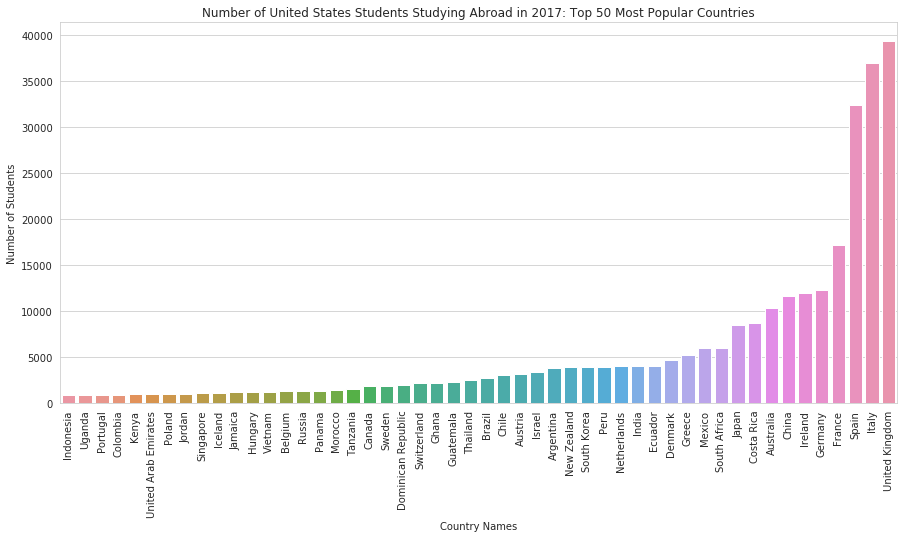

In [8]:
mostPopular50 = fulldata.iloc[-50:] #selecting the bottom 50 rows
matplotlib.rcParams['figure.figsize']=[15, 7] #changing size of plot
sns.set_style("whitegrid")
plt.xticks(rotation='vertical') #rotating labels
bar_count = sns.barplot( x = "Country", y = "Student Count",data = mostPopular50, orient='v')
plt.xlabel('Country Names')
plt.ylabel('Number of Students')
plt.title('Number of United States Students Studying Abroad in 2017: Top 50 Most Popular Countries')
plt.show()

We can see that there exists a large gap between countrie's popularity distribution. Even after we isolated the top 50 most popular country, the distinction between the number of United Students who studies abroad in the top 3 countries and other countries in the top 50 is very visible. The fourth most popular country - France, had about 17,000 students, while the third most popular country - Spain had over 30,00 students.

For the purpose of better picturing the disparity between popularity of countries, we also used all student counts from 103 different countries to create a box-and-whiskers-plot. As we can see in the plot below, the outlier-excluded-maximum of student count is around 5,000 students, and the medium of student count appears to be less than 1,000. There are quite a few outliers representing countries that are much more popular among the students, and within these outliers we see 3 countries standing much further out compared to others - United Kingdom, Italy, and Spain (names found in bargraph above). We will pay special attention to these three countries and see how their attributes may differ from others.

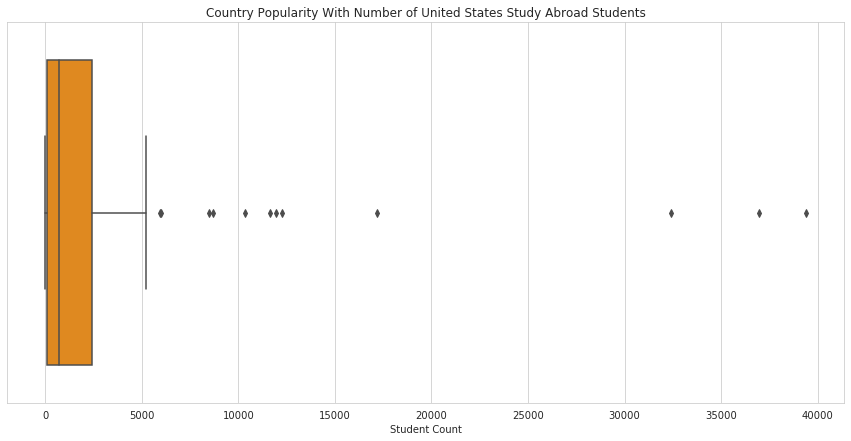

In [9]:
plt.clf()
plt.xlabel('Number of Students')
plt.title('Country Popularity With Number of United States Study Abroad Students')
sns.boxplot(x=fulldata['Student Count'], color = 'darkorange')
plt.show()

<Figure size 1080x504 with 0 Axes>

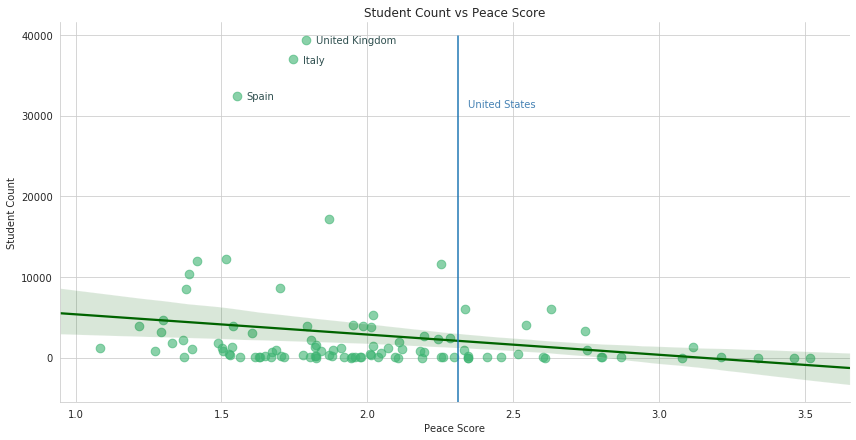

In [72]:
#fit, ax = plt.subplots(figsize = (12,10))
plt.clf()
peace = sns.lmplot(x='Peace Score', y ="Student Count", size=6, aspect =  2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'mediumseagreen'},
                   line_kws={"color":'darkgreen'},data = fulldata)

ax = peace.axes[0,0]
ax.set_title('Student Count vs Peace Score')

dataCoords = list(zip(fulldata['Peace Score'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+0.035, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+0.035, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+0.035, point[1]-400, 'Spain', color = 'darkslategray')
        
#graphing United States
USPeace = peace_index.loc[peace_index['Country'] == 'United States']['2017 score']
plt.axvline(USPeace.values[0],0,0.965)
ax.text(USPeace.values[0] + 0.035, 31000, 'United States', color = 'steelblue')
plt.show()

<Figure size 1080x504 with 0 Axes>

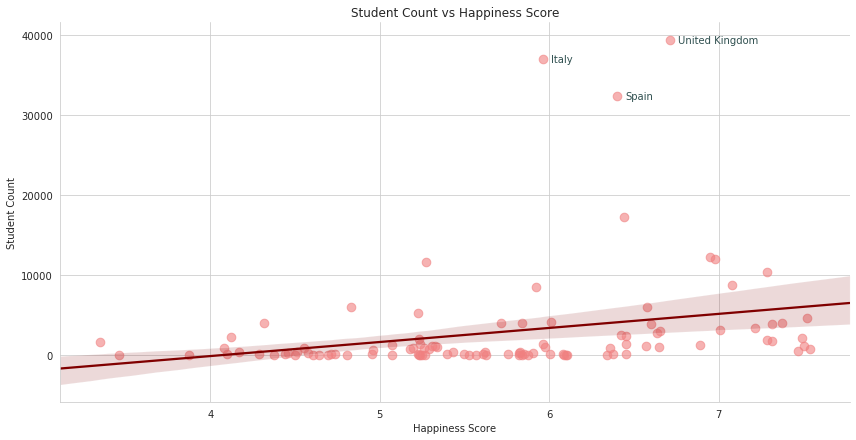

In [11]:
plt.clf()
happiness = sns.lmplot(x='Happiness Score', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'lightcoral'},
                   line_kws={"color":'maroon'},data = fulldata)

ax = happiness.axes[0,0]
ax.set_title('Student Count vs Happiness Score')

dataCoords = list(zip(fulldata['Happiness Score'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+0.045, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+0.045, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+0.045, point[1]-400, 'Spain', color = 'darkslategray')

plt.show()

<Figure size 1080x504 with 0 Axes>

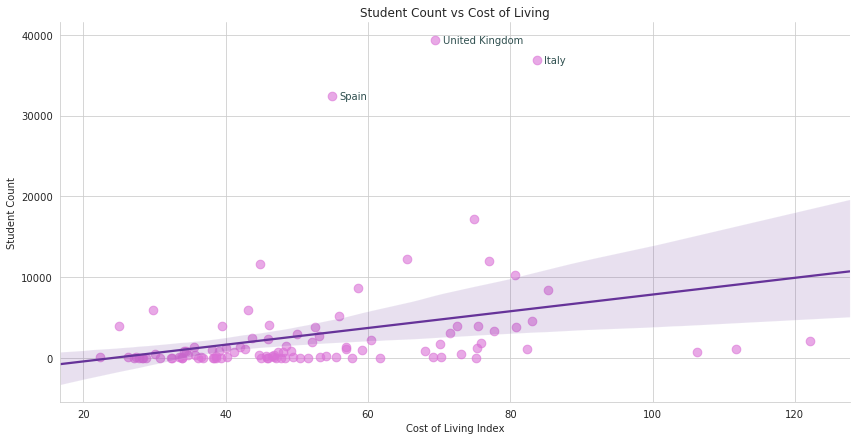

In [12]:
plt.clf()
cost = sns.lmplot(x='Cost of Living Index', y ="Student Count", size=6, aspect = 2, 
                   scatter_kws={"s":75,"alpha":0.6,"color":'orchid'},
                   line_kws={"color":'rebeccapurple'},data = fulldata)

ax = cost.axes[0,0]
ax.set_title('Student Count vs Cost of Living')

dataCoords = list(zip(fulldata['Cost of Living Index'], fulldata['Student Count']))
for i in range(len(dataCoords)):
    point = dataCoords[i]
    if point[1] > 37000: #United Kingdom
        ax.text(point[0]+1, point[1]-400, 'United Kingdom', color = 'darkslategray')
    elif point[1] > 35000: #Italy
        ax.text(point[0]+1, point[1]-400, 'Italy', color = 'darkslategray')
    elif point[1] > 30000: #Spain
        ax.text(point[0]+1, point[1]-400, 'Spain', color = 'darkslategray')

plt.show()

In [13]:
category = []
catkey = ['2 to 3','3 to 4','4 to 5','5 to 6','6 to 7','7 to 8']
for index, row in fulldata.iterrows():
    if row[3] >= 2 and row[3] < 3:
        category.append('2 to 3')
    if row[3] >= 3 and row[3] < 4:
        category.append('3 to 4')
    if row[3] >= 4 and row[3] < 5:
        category.append('4 to 5')
    if row[3] >= 5 and row[3] < 6:
        category.append('5 to 6')
    if row[3] >= 6 and row[3] < 7:
        category.append('6 to 7')
    if row[3] >= 7 and row[3] < 8:
        category.append('7 to 8')

fulldata['Happiness Category'] = category
    
        

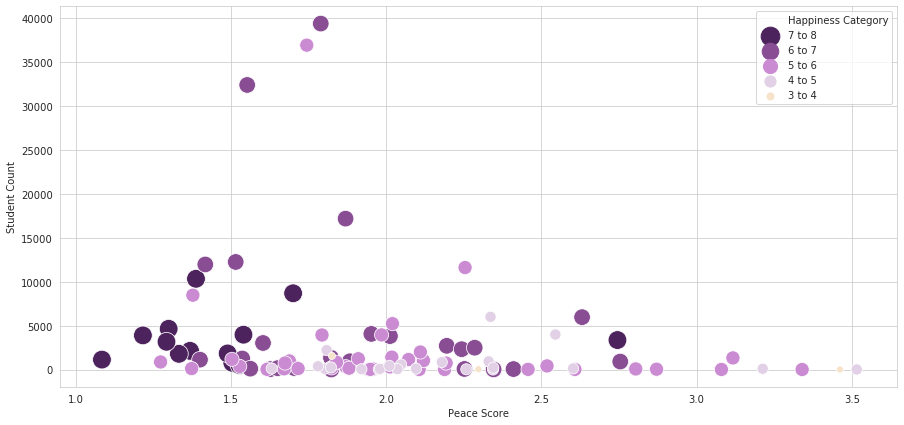

In [14]:
#cmap = sns.cubehelix_palette(dark = .3, light = .8, as_cmap=True)
palette = {"2 to 3":"#FFF8EF","3 to 4":"#F7E3CA", "4 to 5":"#E2D1E6", "5 to 6":"#ca8bd2",
           "6 to 7":"#894d94", "7 to 8":"#4D235D"}

sizesdict = {"2 to 3":2,"3 to 4":4, "4 to 5":6, "5 to 6":8,
           "6 to 7":10, "7 to 8":12}

hap_sort = fulldata.sort_values("Happiness Score", ascending = False)
hap_peace = sns.scatterplot(x="Peace Score", y="Student Count", hue="Happiness Category",
                            size = "Happiness Category",
                            sizes = (50,350),
                            palette=palette,
                            data = hap_sort)
hap_peace


In [35]:
country_geo = 'world-countries.json'
palette = sns.cubehelix_palette(8, start=.5, rot=-.75)
map = folium.Map(location=[100, 0], zoom_start=1.5)
map.choropleth(geo_data=country_geo, data=fulldata,
              columns=['Country', 'Student Count'],
              key_on='feature.properties.name',
              fill_color='YlOrRd', nan_fill_color = 'cornsilk',
              fill_opacity=0.7,
              line_opacity=0.2,
              legend_name='Number of U.S. Students')
map